In [139]:
import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPopBis
from flecs.sc.utils import get_cell_indices
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (16,8)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(),
                                  "datasets", "Paul15", "processed", "adata_processed_with_paths_magic.h5ad")
                     )

In [3]:
len(adata)

7296

In [4]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
cmp_unsorted_adata = adata[cmp_cells + unsorted_cells]

## Model

In [5]:
batch_size = cmp_unsorted_adata.shape[0] // 2

In [6]:
mycellpop = GRNCellPopBis(adata=adata, batch_size=batch_size, n_latent_var=50, use_2nd_order_interactions=False)

## Load weights

In [7]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "logs", "trained_mycellpop_nov_3_20.pt"), 
                                map_location=torch.device('cpu'))

In [8]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

## Plotting

In [9]:
sc.pp.neighbors(cmp_unsorted_adata, n_neighbors=30, n_pcs=50)
highly_var_gene_list = list(adata.var.iloc[np.where(adata.X.std(axis=0) > 5)[0]].index)

In [10]:
with torch.no_grad():
    
    unsorted_velocities = []
    
    for i in tqdm(range(cmp_unsorted_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_unsorted_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(torch.cat((gene_expr, 
                                                        torch.zeros(batch_size, 50, 1)), dim=1))
        
        unsorted_velocities.append(velocity[:, :-50])
        
unsorted_velocities = torch.cat(unsorted_velocities).cpu().numpy()[:, :, 0]
cmp_unsorted_adata.layers["velocity"] = unsorted_velocities
cmp_unsorted_adata.layers["X"] = cmp_unsorted_adata.X

100%|████████████████████████████████████████████████████████████████████████████| 2/2 [01:10<00:00, 35.26s/it]


In [11]:
scv.tl.velocity_graph(cmp_unsorted_adata, xkey="X", gene_subset=highly_var_gene_list, n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


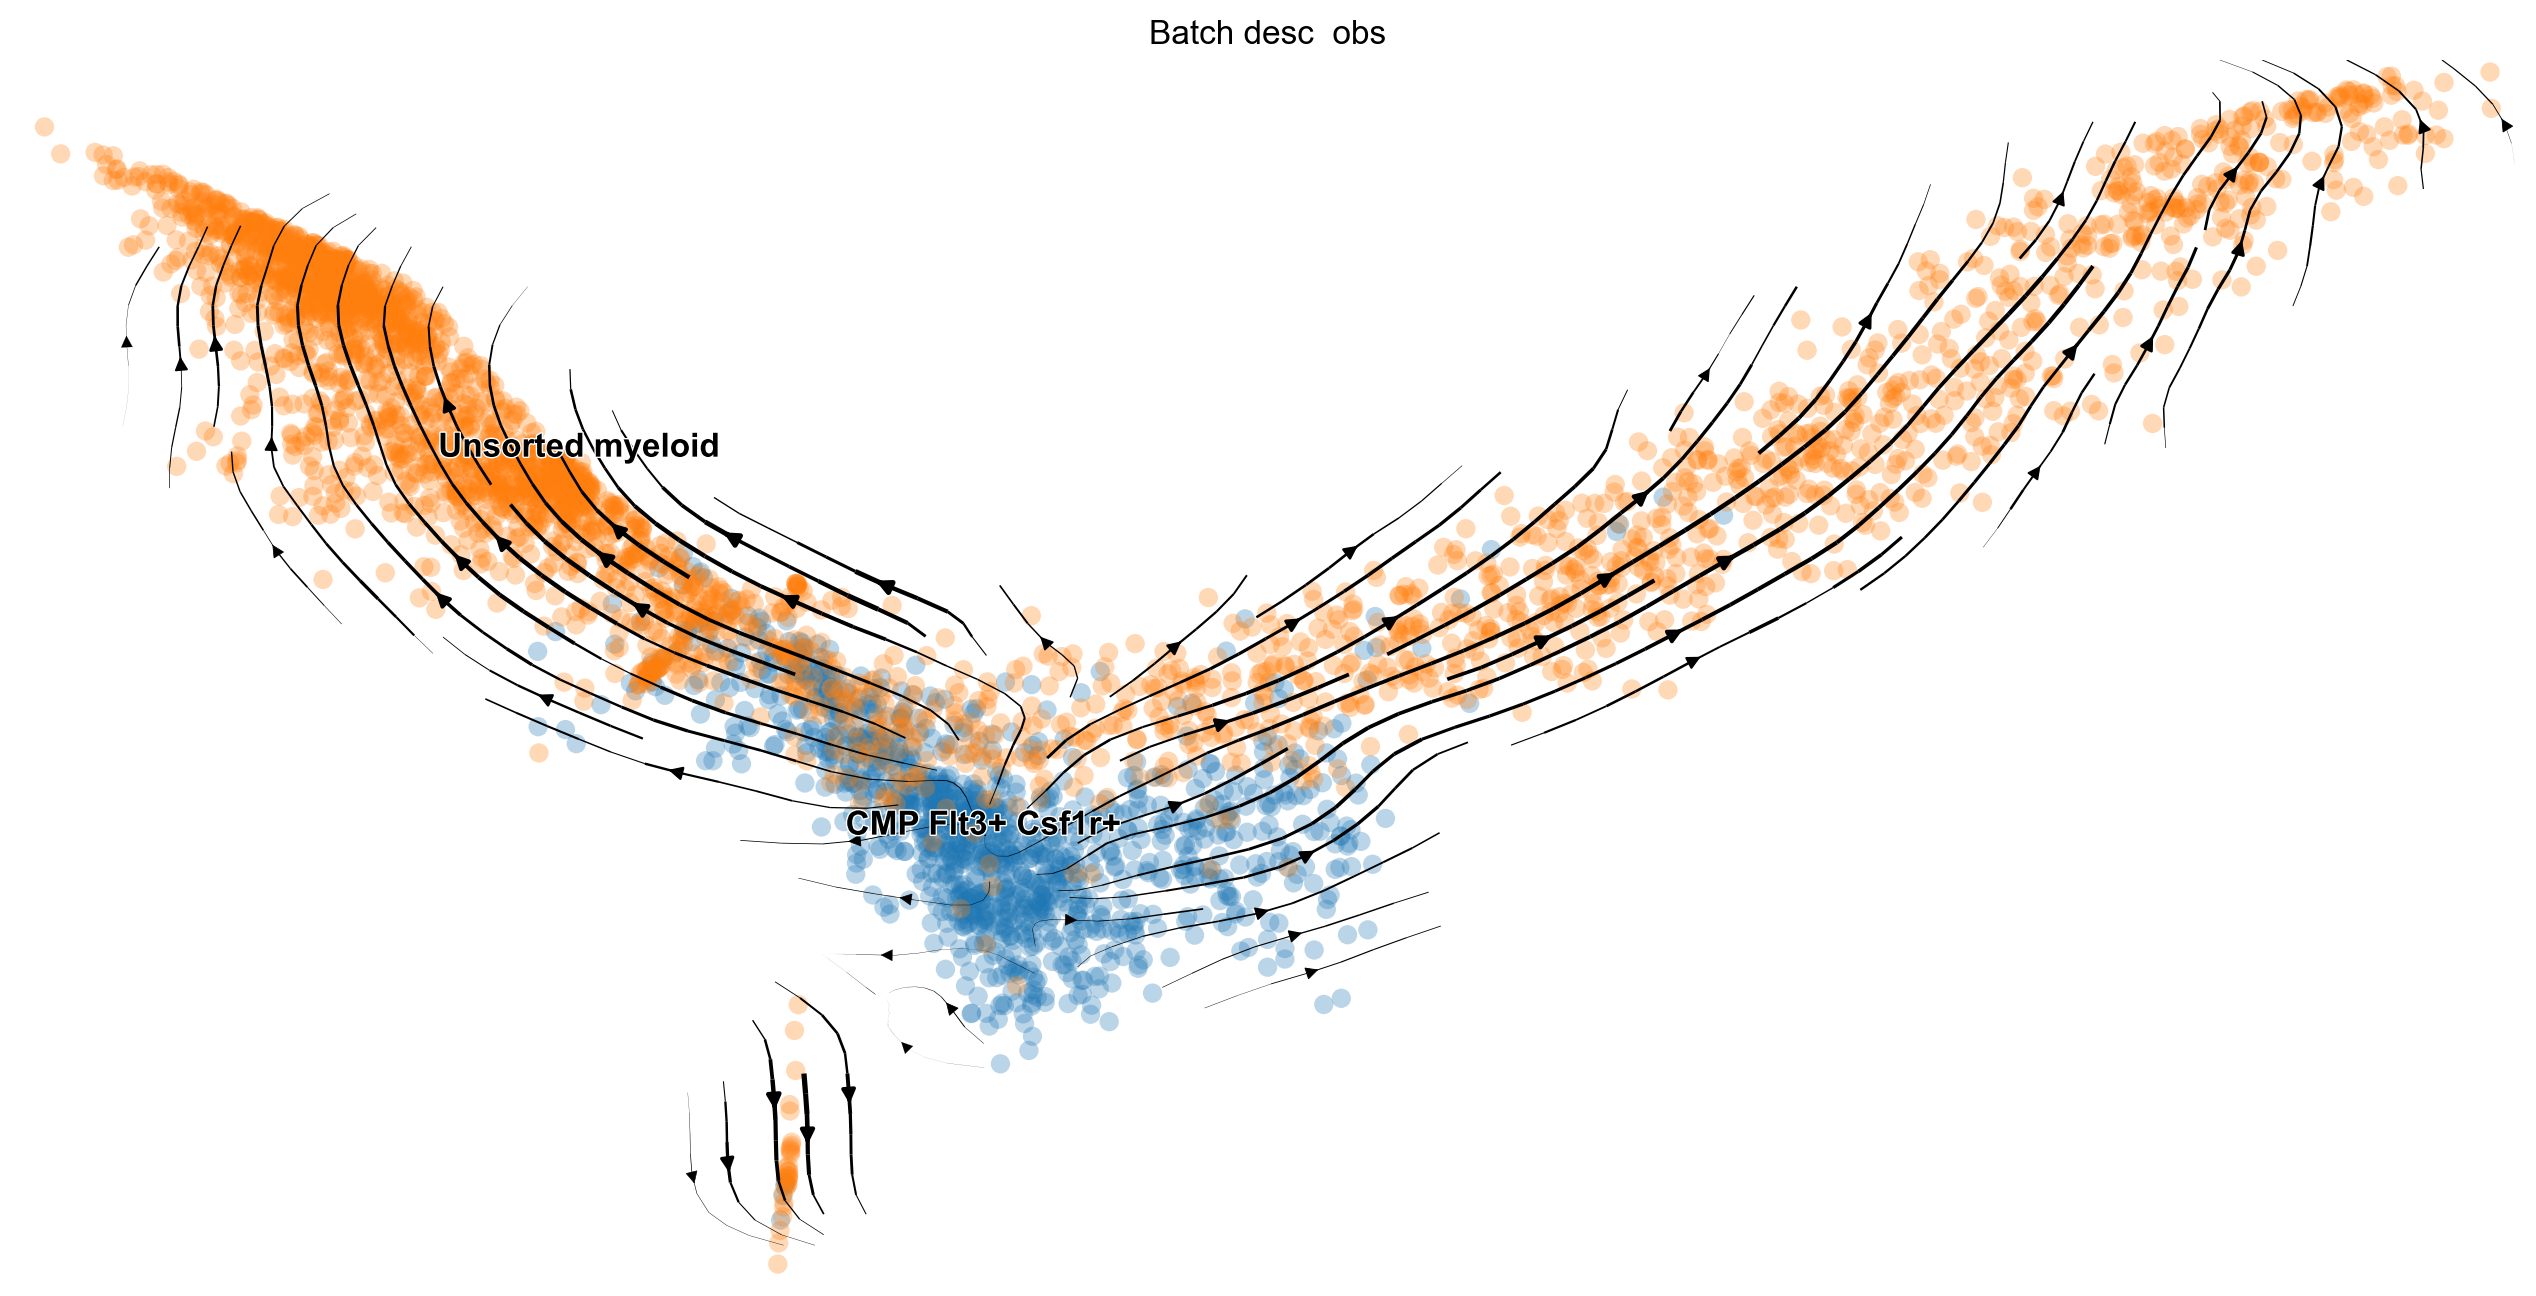

In [12]:
scv.pl.velocity_embedding_stream(cmp_unsorted_adata, basis='umap', color="Batch_desc", layer="obs")

## Simulate trajectories

In [127]:
cmp_adata = adata[cmp_cells]

In [128]:
batch_size = cmp_adata.shape[0] // 64
mycellpop.change_batch_size(batch_size)

In [129]:
path_length = 10
all_traj = []

with torch.no_grad():
    
    for i in tqdm(range(cmp_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        
        mycellpop.set_visible_state(gene_expr)
        
        traj = simulate_deterministic_trajectory(mycellpop, torch.linspace(0, path_length-1, path_length))
        traj = traj[:, :, :mycellpop.n_genes, 0]

        all_traj.append(traj)

100%|██████████████████████████████████████████████████████████████████████████| 64/64 [12:19<00:00, 11.55s/it]


In [130]:
all_traj_cat = torch.cat(all_traj)

In [131]:
obs_times = torch.cat([torch.linspace(0, path_length-1, path_length)[None]]*len(all_traj_cat)).reshape(-1).numpy()

In [132]:
traj_adata = ad.AnnData(all_traj_cat.reshape(-1, 4000).numpy(), obs=obs_times)

In [133]:
traj_adata.obs = traj_adata.obs.rename(columns={0: "time"})

In [134]:
sc.tl.pca(traj_adata, svd_solver="arpack", n_comps=100)
sc.pp.neighbors(traj_adata, n_neighbors=100, n_pcs=100)
sc.tl.umap(traj_adata, min_dist=0.3)

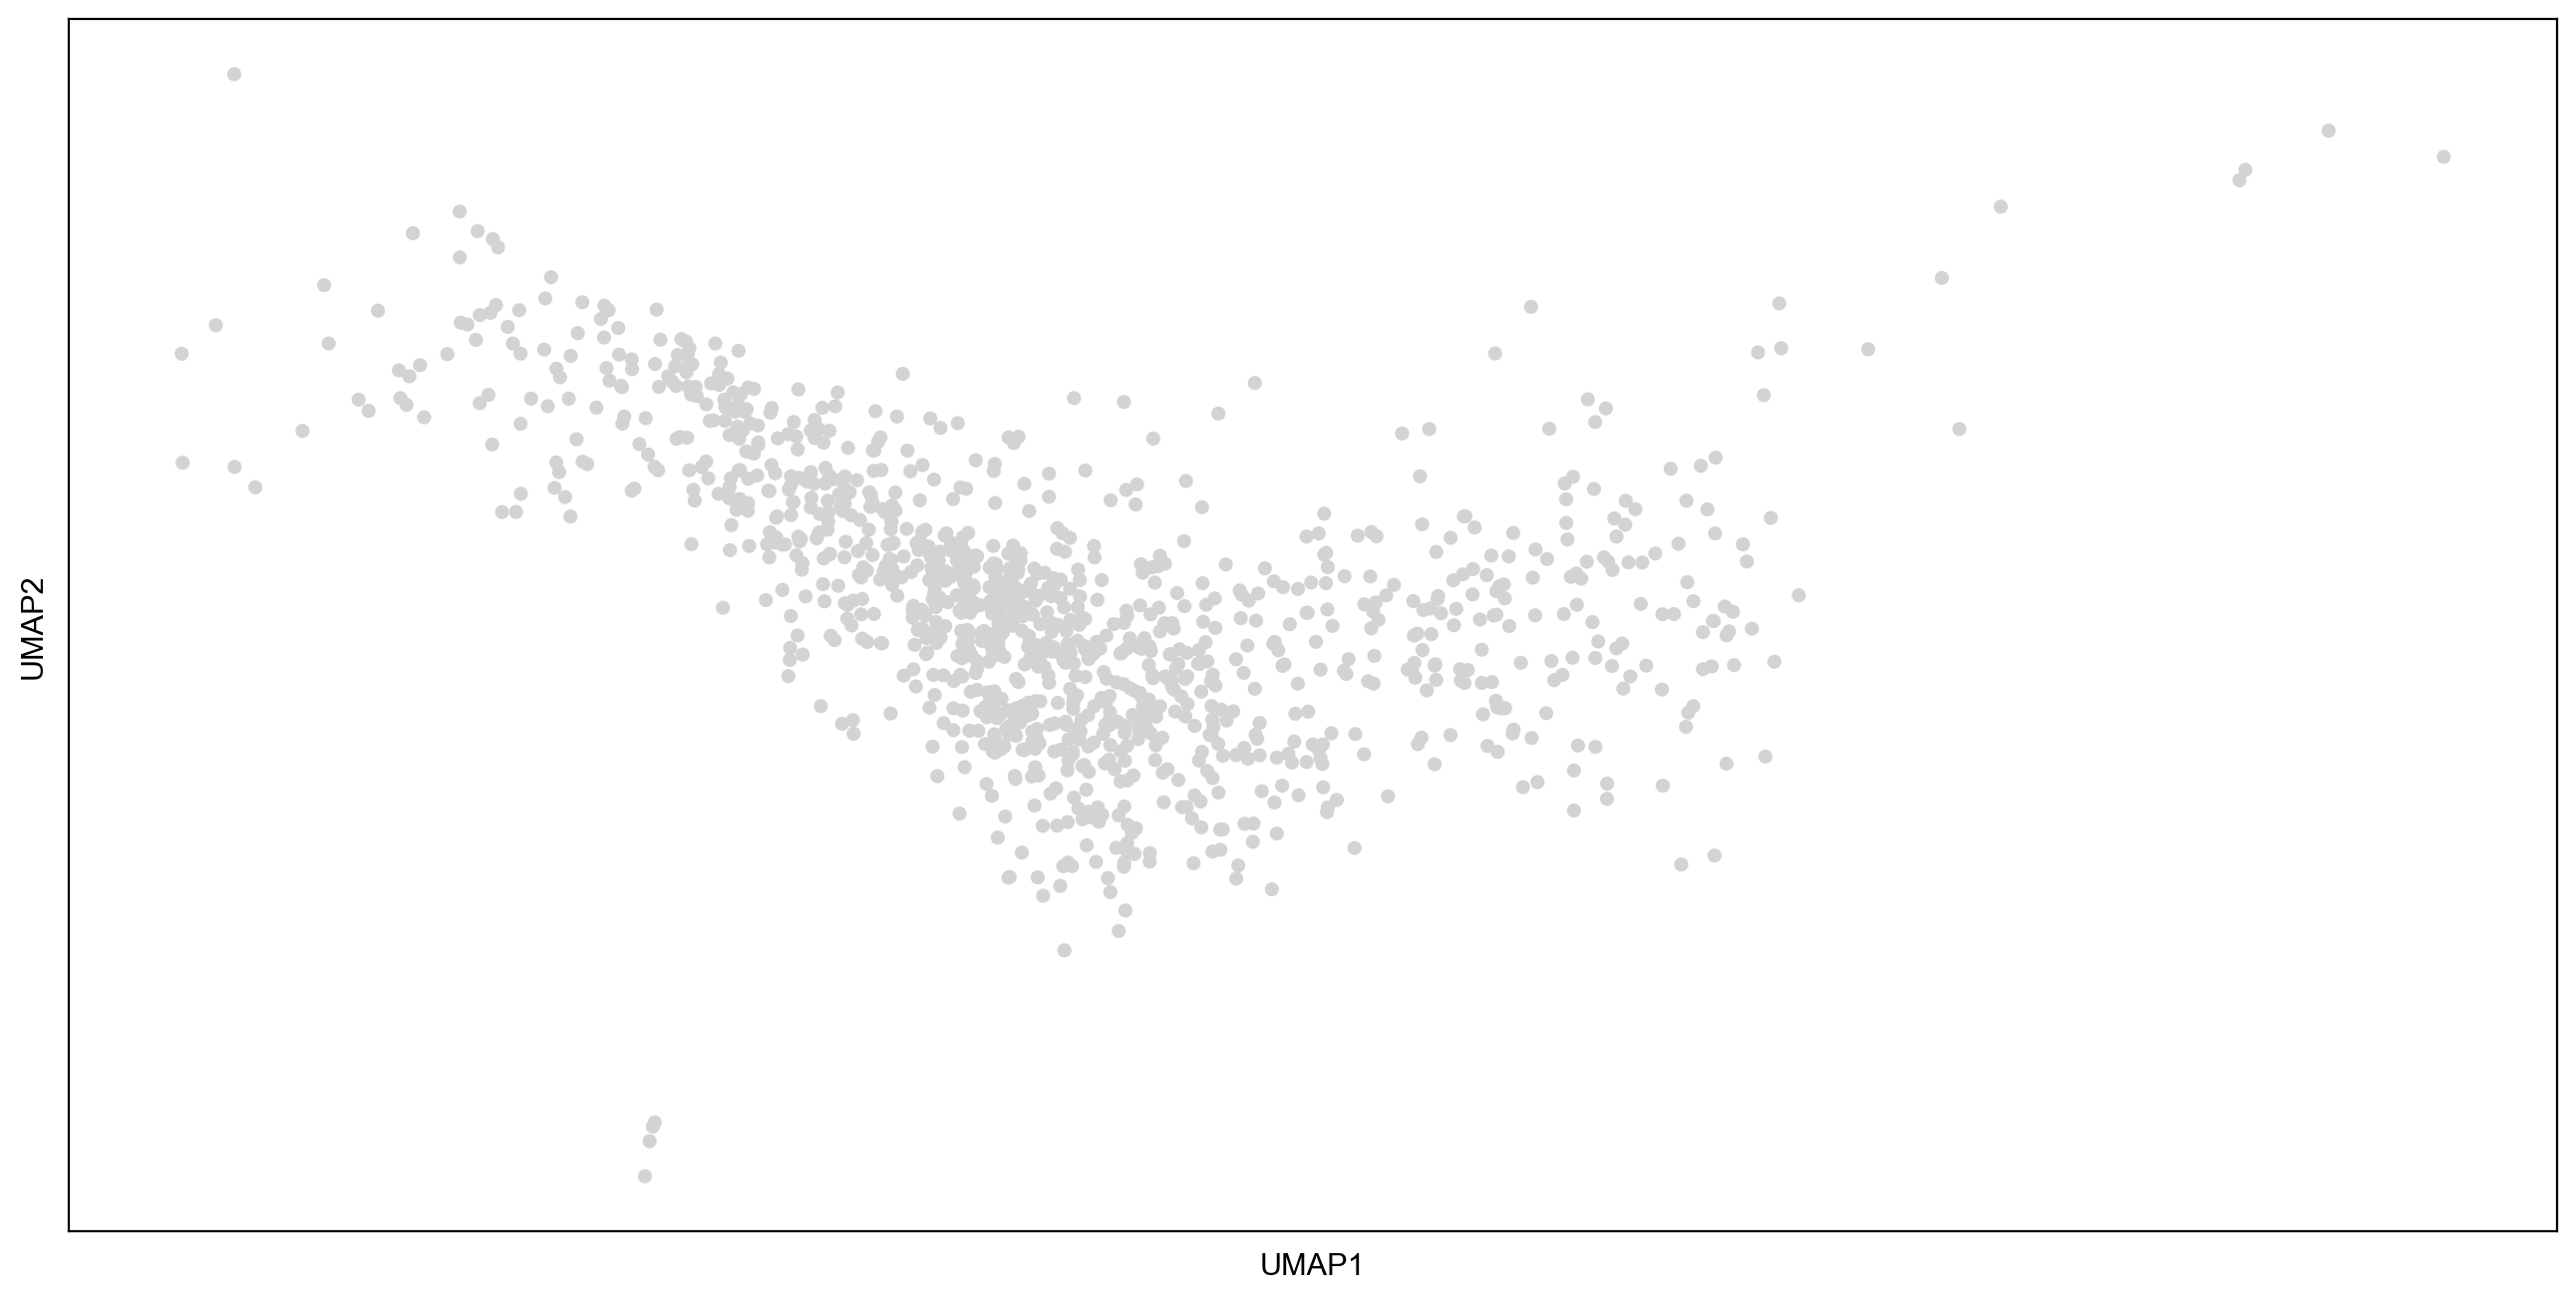

In [135]:
sc.pl.umap(cmp_adata)

In [144]:
traj_adata

AnnData object with n_obs × n_vars = 11520 × 4000
    obs: 'time'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [149]:
init_coord = traj_adata[traj_adata.obs["time"] == 0].obsm["X_umap"]

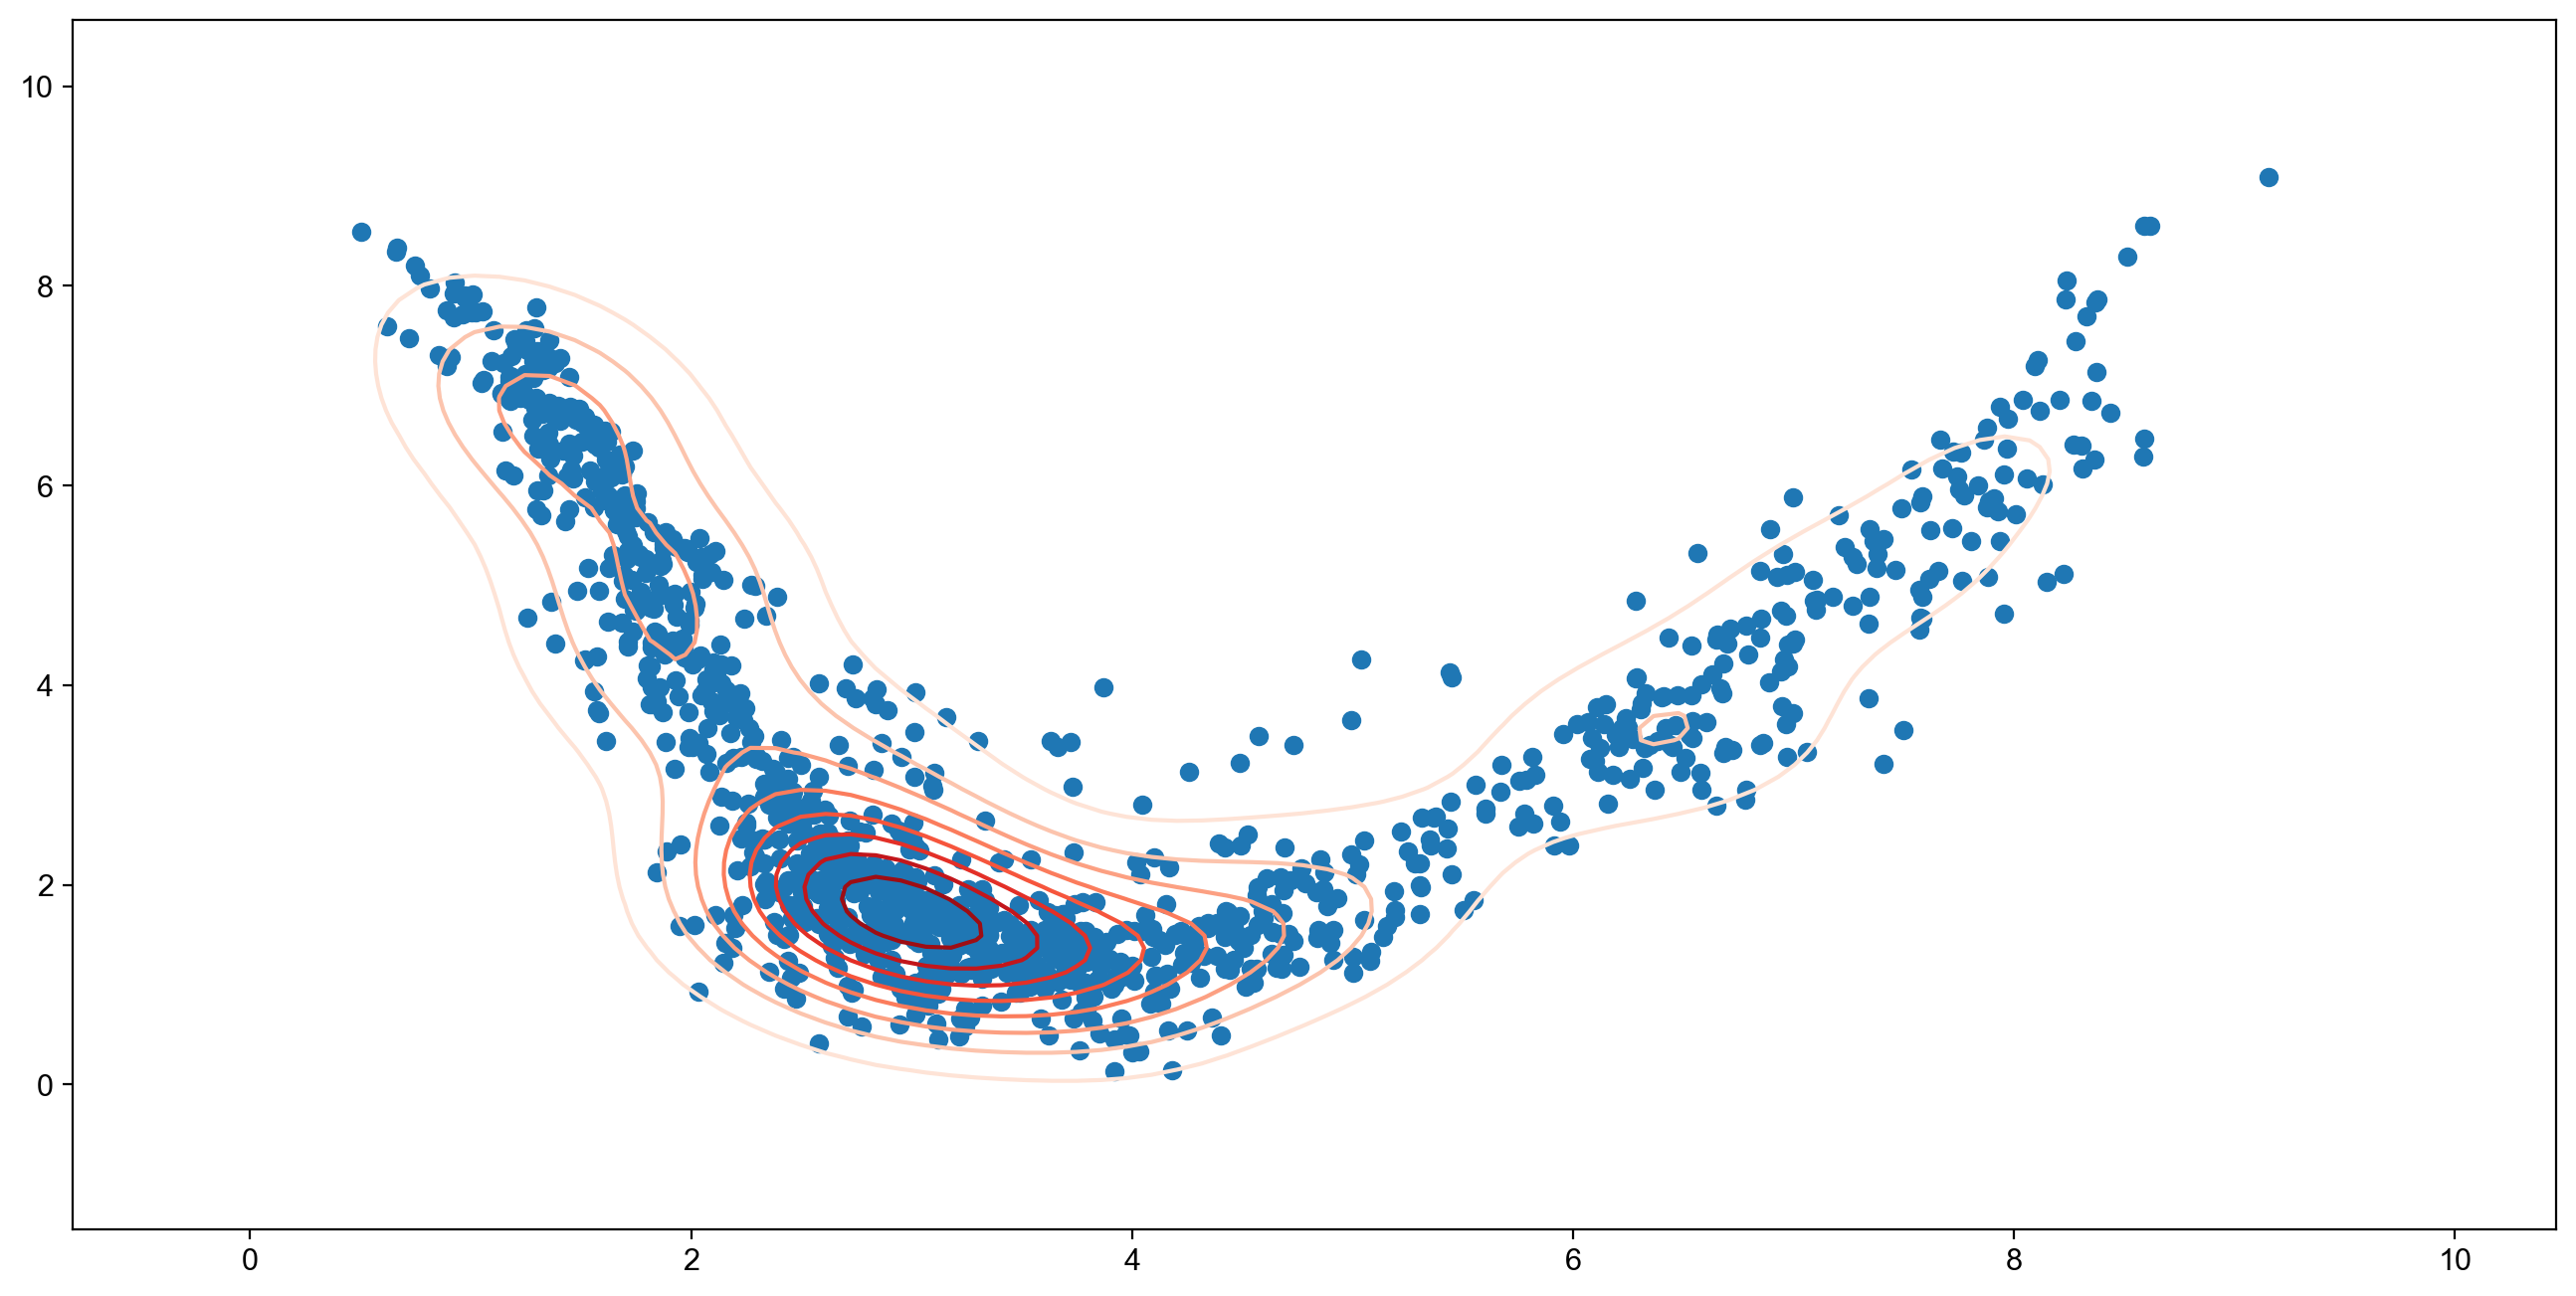

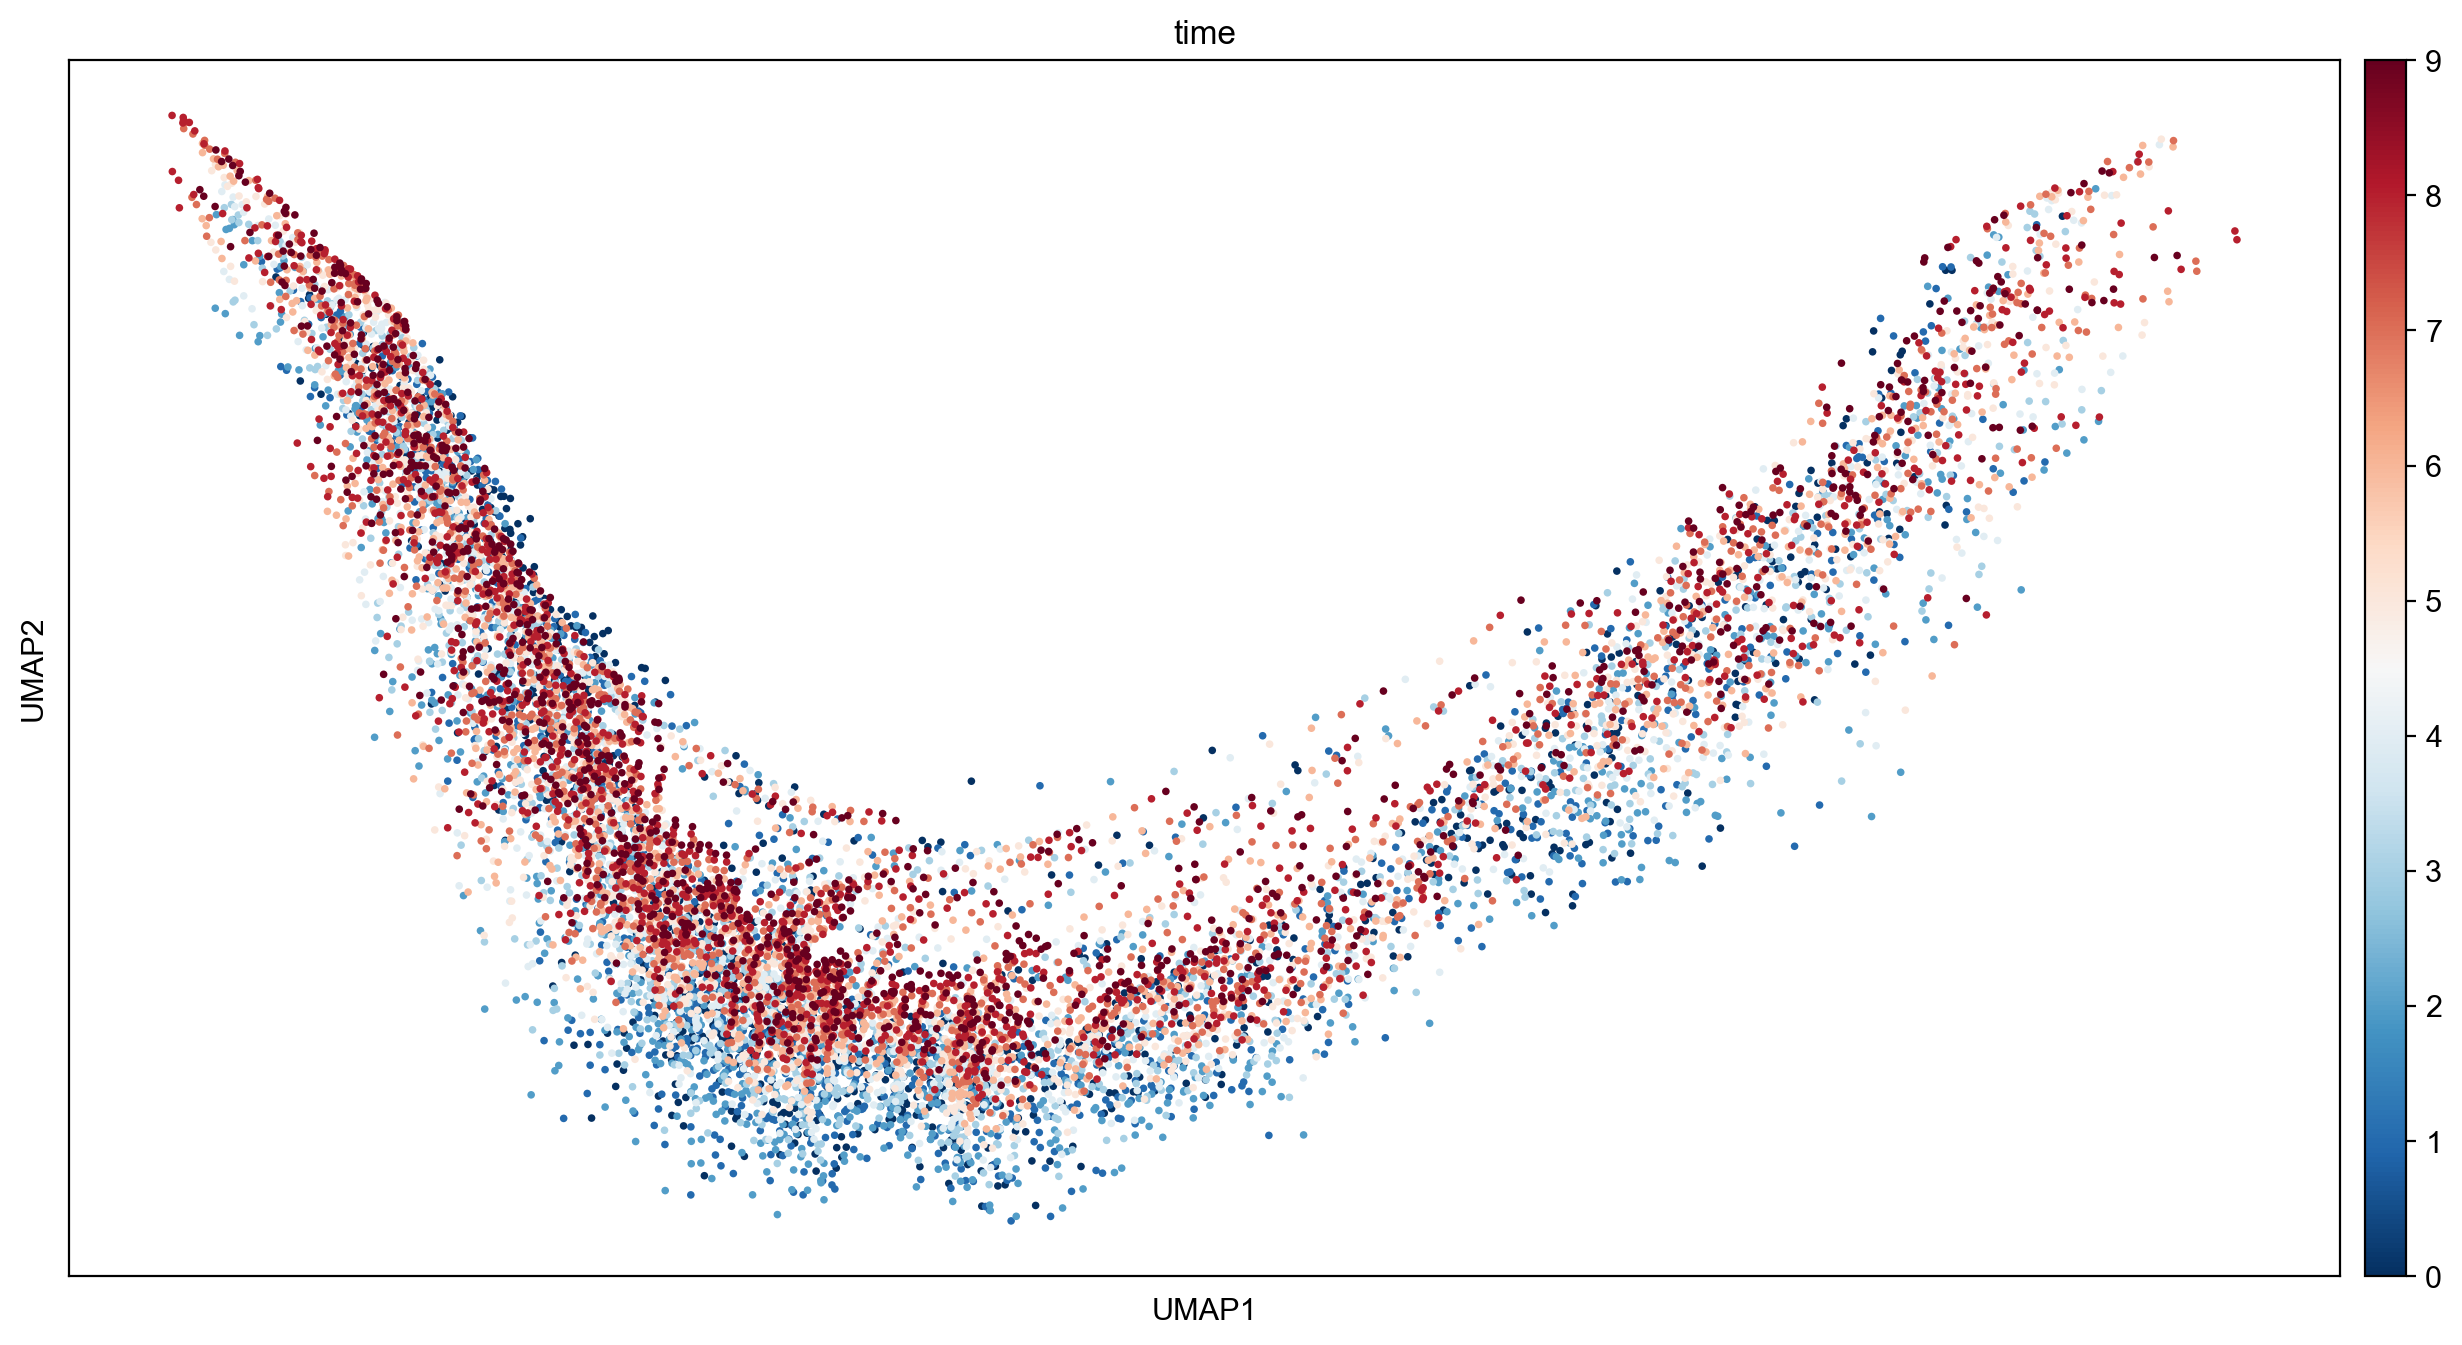

In [152]:
sns.kdeplot(init_coord[:, 0], init_coord[:, 1], cmap="Reds")
plt.scatter(init_coord[:, 0], init_coord[:, 1])
sc.pl.umap(traj_adata, color="time", 
           legend_loc='right margin', 
           palette="Accent",
           size=30
          )

## Mistake when simulating from all CMP + unsorted

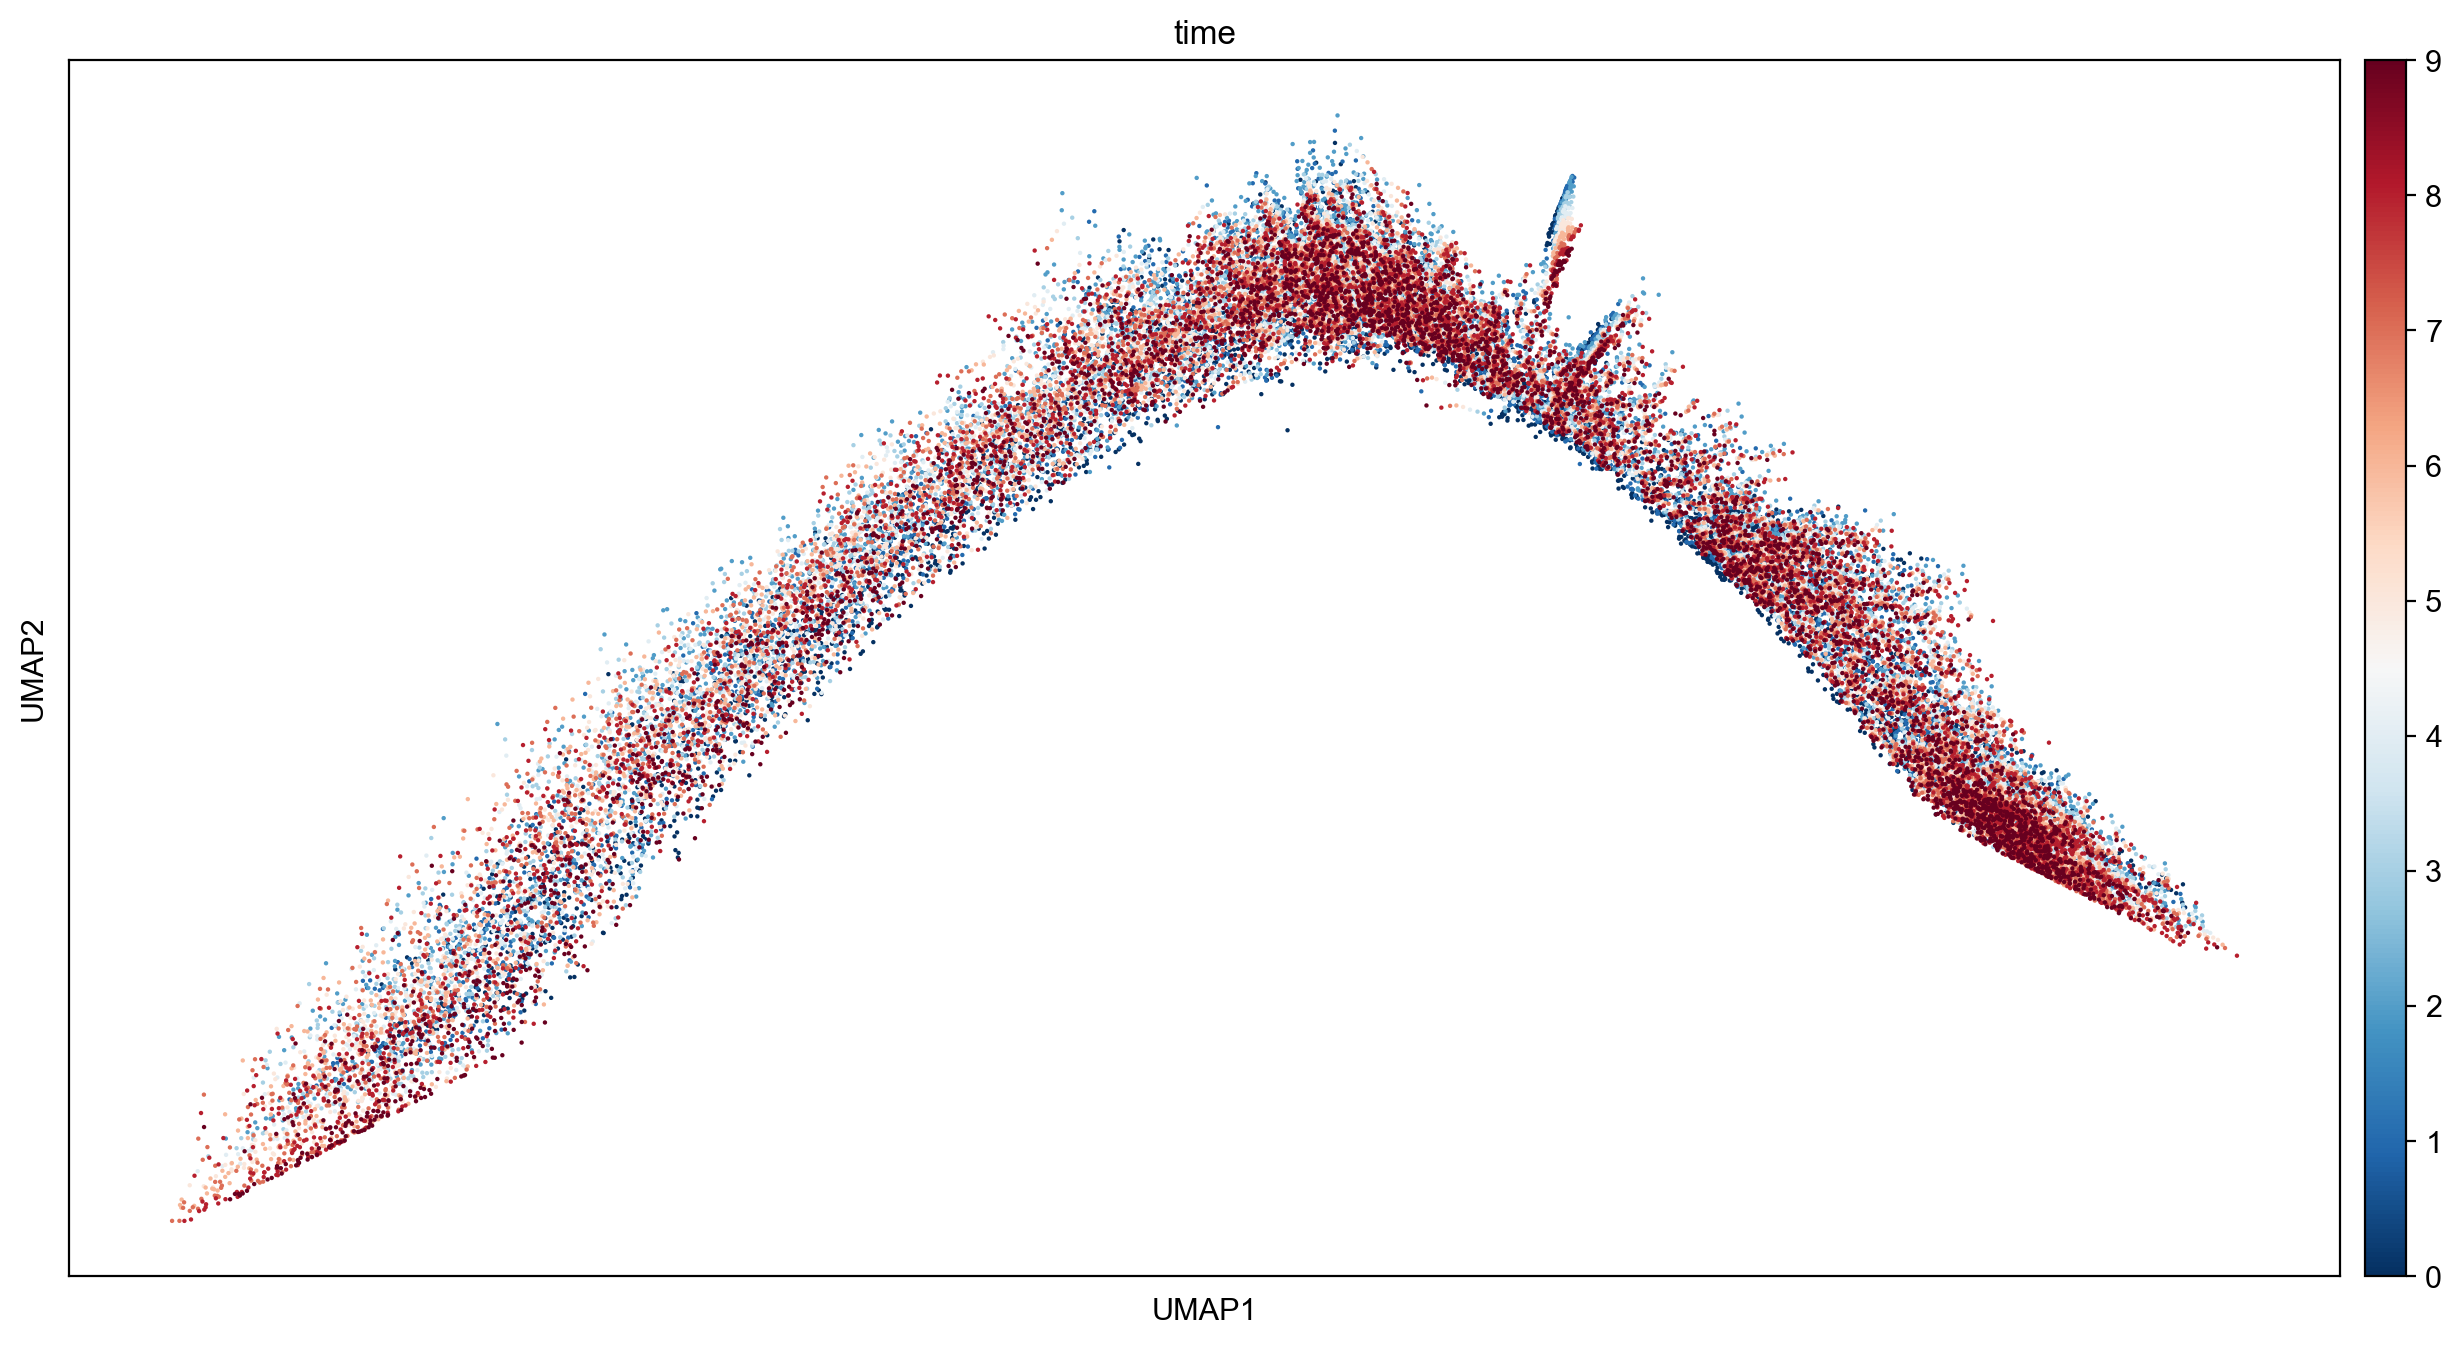

In [123]:
sc.pl.umap(traj_adata, color="time", 
           legend_loc='right margin', 
           palette="Accent",
           size=10
          )